# **Xception vs DenseNet: From-Scratch Implementation, Fine-Tuning, and Comparison**

This notebook demonstrates the implementation and training of Xception and DenseNet models from scratch, as well as fine-tuning pre-trained versions of both using TensorFlow. The performance of both approaches will be evaluated and compared on the same dataset to highlight the strengths and weaknesses of each model.


In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv('/kaggle/input/emnist/emnist-balanced-train.csv', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df.shape

(112800, 785)

In [10]:
X_train = train_df.loc[:, 1:]
y_train = train_df.loc[:, 0]

X_train.shape, y_train.shape

((112800, 784), (112800,))

In [11]:
label_map = pd.read_csv(
    "/kaggle/input/emnist/emnist-balanced-mapping.txt", 
    delimiter=' ', 
    index_col=0, 
    header=None
).squeeze("columns")

label_map.head()

0
0    48
1    49
2    50
3    51
4    52
Name: 1, dtype: int64

In [12]:
label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [13]:
# Sample entry number 42
sample_image = X_train.iloc[42]
sample_label = y_train.iloc[42]

sample_image.shape, sample_label

((784,), 23)

Label entry 42: N


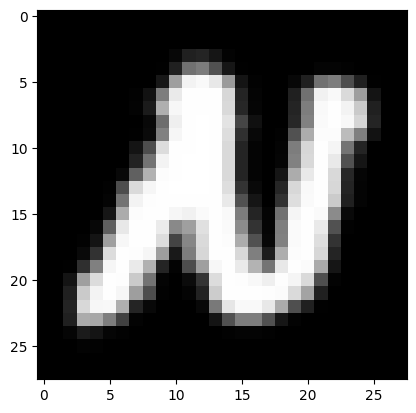

In [14]:
def reshape_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(reshape_and_rotate(sample_image.values), cmap=plt.cm.gray)

plt.show()

In [15]:
# Convert DataFrame to NumPy array
X_train_array = X_train.values  

X_train_reshaped = X_train_array.reshape(-1, 28, 28)

# Preprocessing steps
X_train_reshaped = X_train_reshaped.astype('float32')

# Step 1: Pixel value normalization (0-1 scaling)
X_train_normalized = X_train_reshaped / 255.0

# Step 2: Z-score normalization (NOT USED)
# mean = X_train_normalized.mean()
# std = X_train_normalized.std()
#X_train_standardized = (X_train_normalized - mean) / std

In [16]:
from sklearn.model_selection import train_test_split

number_of_classes=47

# reshape X_train 
X_train = X_train_normalized.reshape(-1, 28, 28, 1).astype('float32')

# One-hot encoded y_train
y_train = tf.keras.utils.to_categorical(y_train, number_of_classes)

# Split into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42 
)

In [79]:
def preprocess_augmentation_images(image, label):
    # Flip the image left to right
    image = tf.image.flip_left_right(image)
    
    # Rotate the image 90 degrees clockwise
    image = tf.image.rot90(image, k=1)
    
    return image, label
 
# Create TensorFlow datasets
train_dataset_res = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
train_dataset_res = train_dataset_res.map(preprocess_augmentation_images).batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset_res = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
val_dataset_res = val_dataset_res.map(preprocess_augmentation_images).batch(64).prefetch(tf.data.AUTOTUNE)

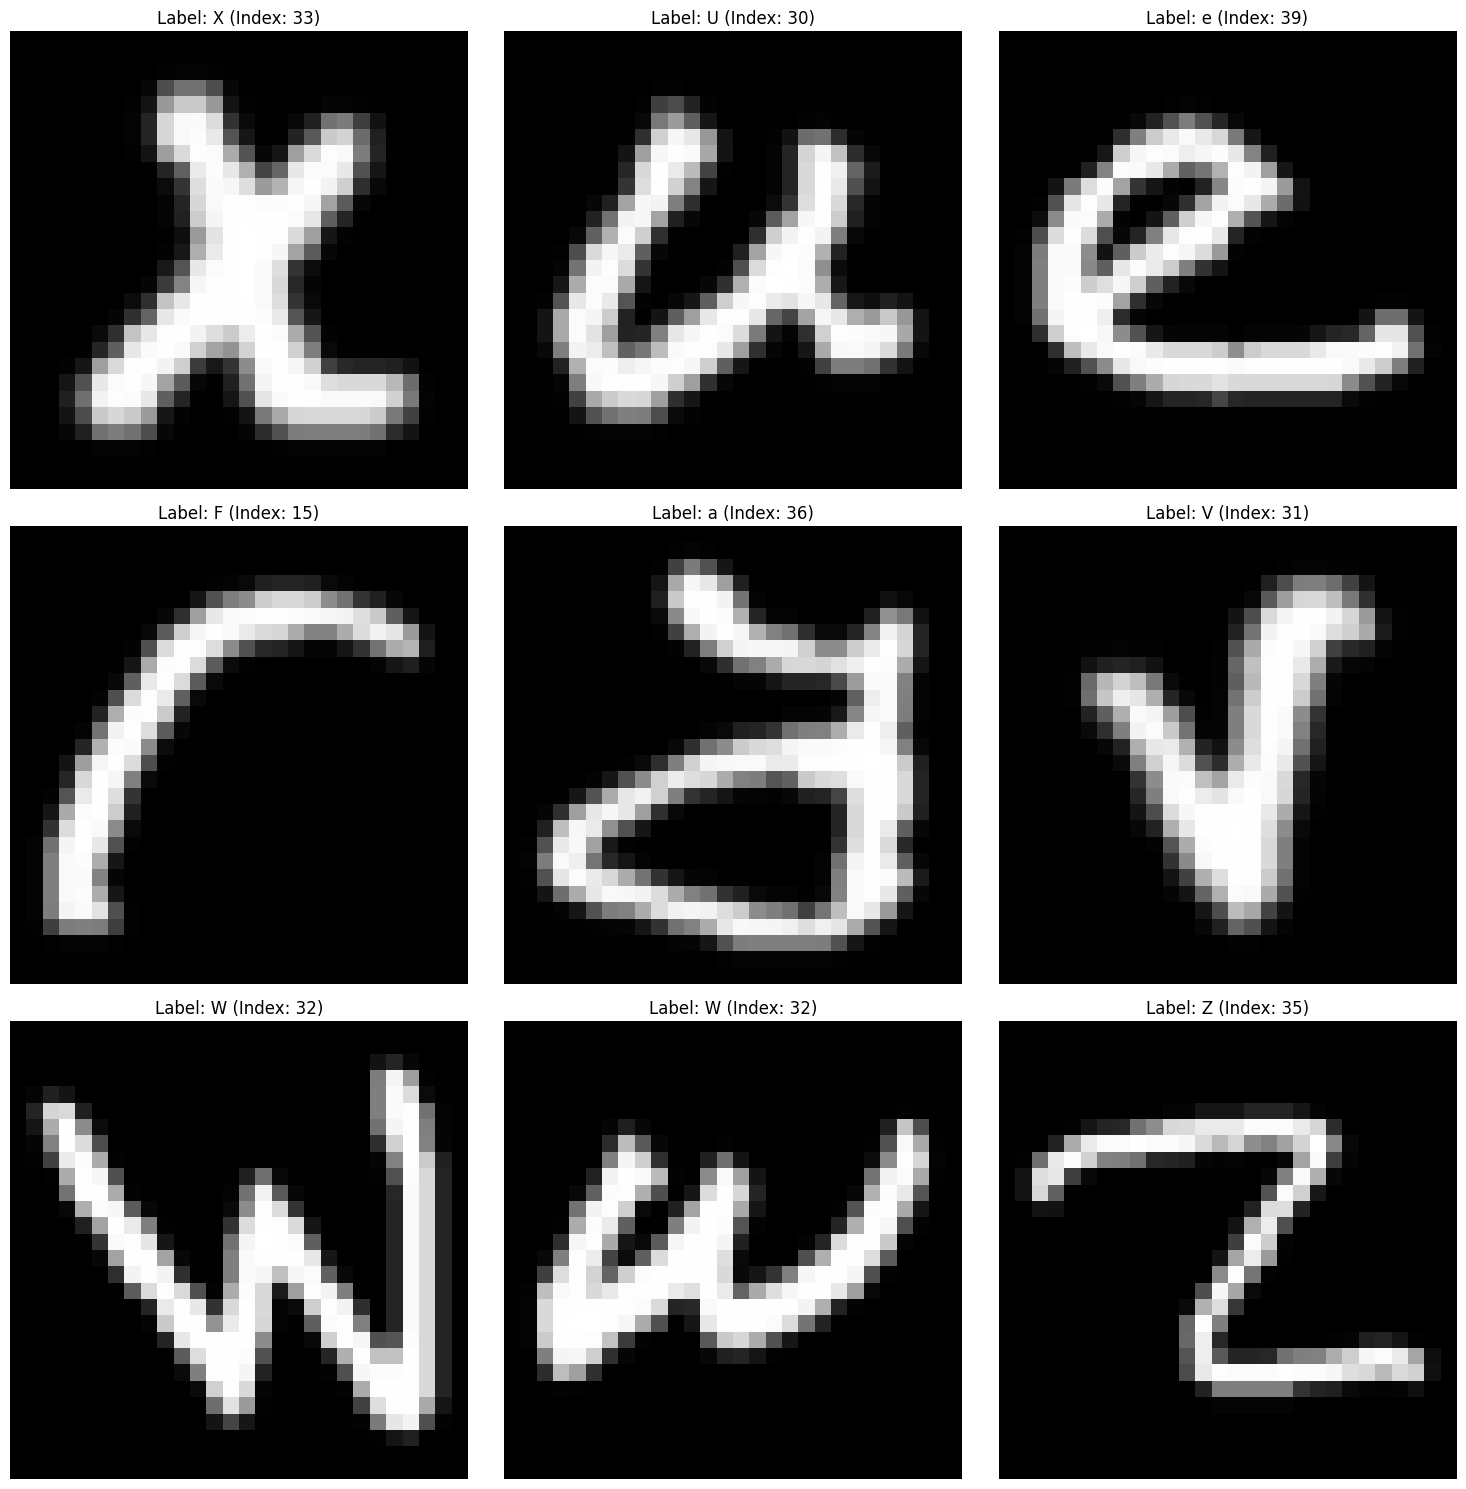

In [20]:
def visualize_images(dataset, label_dict, num_images=9):
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        # Find the index of the max value in the one-hot encoded label
        label_index = np.argmax(label[0])
        
        # Get the corresponding character from the label dictionary
        label_char = label_dict[label_index]
        
        plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy(),cmap= 'gray')  # Take first image from batch
        plt.title(f'Label: {label_char} (Index: {label_index})')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
# Visualize training images
visualize_images(train_dataset_res, label_dictionary)

## Resnet

In [21]:
def identity_block(X, f, filters):
    regularizer = tf.keras.regularizers.l2(1e-4)
    
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [22]:
def convolutional_block(X, f, filters,s=2):
    
    regularizer = tf.keras.regularizers.l2(1e-4)
    # Retrieve Filters
    F1, F2, F3 = filters
    kernel_initializetion= glorot_uniform(seed=0)
    # Save the input value
    X_shortcut = X

    ### MAIN PATH ###
    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(s, s), kernel_initializer=kernel_initializetion, kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', kernel_initializer=kernel_initializetion, kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), kernel_initializer=kernel_initializetion, kernel_regularizer=regularizer)(X)
    X = BatchNormalization(axis=3,)(X)

    ### SHORTCUT PATH ###
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), kernel_initializer=kernel_initializetion, kernel_regularizer=regularizer)(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [26]:
# Utils
resnet_checkpoint = ModelCheckpoint('resnet.keras',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')

# F1 Score function
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  # Round predicted values to 0 or 1

    tp = tf.reduce_sum(y_true * y_pred)  # True positives
    fp = tf.reduce_sum((1 - y_true) * y_pred)  # False positives
    fn = tf.reduce_sum(y_true * (1 - y_pred))  # False negatives

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [31]:
from tensorflow.keras.metrics import Precision, Recall
from keras.initializers import glorot_uniform
from tensorflow.keras import backend as K
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D ,GlobalAveragePooling2D
from keras.models import Model

# Define input shape and number of classesstride
input_shape = (28, 28, 1)
classes = 47
regularizer = tf.keras.regularizers.l2(1e-4)

kernel_initializetion= glorot_uniform(seed=0)

# Define the input as a tensor with shape input_shape
X_input = Input(input_shape)

# Zero-Padding
X = ZeroPadding2D((3, 3))(X_input)

# Stage 1 - Modify to reduce downsampling
X = Conv2D(64, (3, 3), strides=(1, 1),kernel_initializer=kernel_initializetion, kernel_regularizer=regularizer)(X)
X = BatchNormalization(axis=3)(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

# Stage 3
X = convolutional_block(X, f=3, filters=[128, 128, 512],s=2)
X = identity_block(X, 3, [128, 128, 512])
X = identity_block(X, 3, [128, 128, 512])
X = identity_block(X, 3, [128, 128, 512])

# Stage 4
X = convolutional_block(X, f=3, filters=[256, 256, 1024],s=2)
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])

# Stage 5
X = convolutional_block(X, f=3, filters=[512, 512, 2048],s=2)
X = identity_block(X, 3, [512, 512, 2048])
X = identity_block(X, 3, [512, 512, 2048])

# AVGPOOL
X = AveragePooling2D((2, 2), name='avg_pool')(X)

# Output layer
X = Flatten()(X)
X = Dense(classes, activation='softmax')(X)

# Create model
resnet_50 = Model(inputs=X_input, outputs=X, name='ResNet50')

resnet_50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_score])

resnet_50.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 34, 34, 1) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 32, 32,    │        640 │ zero_padding2d_3… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_129[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_120      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ activation_120[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_130 (Conv2D) │ (None, 8, 8, 128) │      8,320 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_130[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_121      │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_131 (Conv2D) │ (None, 8, 8, 128) │    147,584 │ activation_121[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_131[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_122      │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 8, 8, 512) │     66,048 │ activation_122[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 8, 8, 512) │     33,280 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_132[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_133[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_123      │ (None, 8, 8, 512) │          0 │ add_39[0][0]      │
│ (Activation)        │                   │            │                 

 Total params: 23,332,271 (89.01 MB)

 Trainable params: 23,281,967 (88.81 MB)

 Non-trainable params: 50,304 (196.50 KB)

In [32]:
resnet_history = resnet_50.fit(train_dataset_res, validation_data=val_dataset, epochs=15, callbacks=[resnet_checkpoint])

Epoch 1/15


I0000 00:00:1734554157.822469     100 service.cc:145] XLA service 0x7c22e00035d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734554157.822533     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   2/1587 ━━━━━━━━━━━━━━━━━━━━ 1:28 56ms/step - accuracy: 0.0117 - f1_score: 0.0417 - loss: 6.7380 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00   

I0000 00:00:1734554174.358262     100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1734554174.396162     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1587/1587 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6741 - f1_score: 0.0482 - loss: 2.8007 - precision_3: 0.7585 - recall_3: 0.6194
Epoch 1: val_accuracy improved from -inf to 0.77544, saving model to resnet.keras
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 134s 58ms/step - accuracy: 0.6742 - f1_score: 0.0482 - loss: 2.8004 - precision_3: 0.7585 - recall_3: 0.6194 - val_accuracy: 0.7754 - val_f1_score: 0.0525 - val_loss: 1.7377 - val_precision_3: 0.8227 - val_recall_3: 0.7382
Epoch 2/15
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8302 - f1_score: 0.0528 - loss: 1.3842 - precision_3: 0.8652 - recall_3: 0.7967
Epoch 2: val_accuracy improved from 0.77544 to 0.83910, saving model to resnet.keras
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8302 - f1_score: 0.0528 - loss: 1.3841 - precision_3: 0.8652 - recall_3: 0.7967 - val_accuracy: 0.8391 - val_f1_score: 0.0529 - val_loss: 1.0245 - val_precision_3: 0.8761 - val_recall_3: 0.8042
Epoch 3/15
1586/1587 ━━━━━━━━━━━━━━━━━━

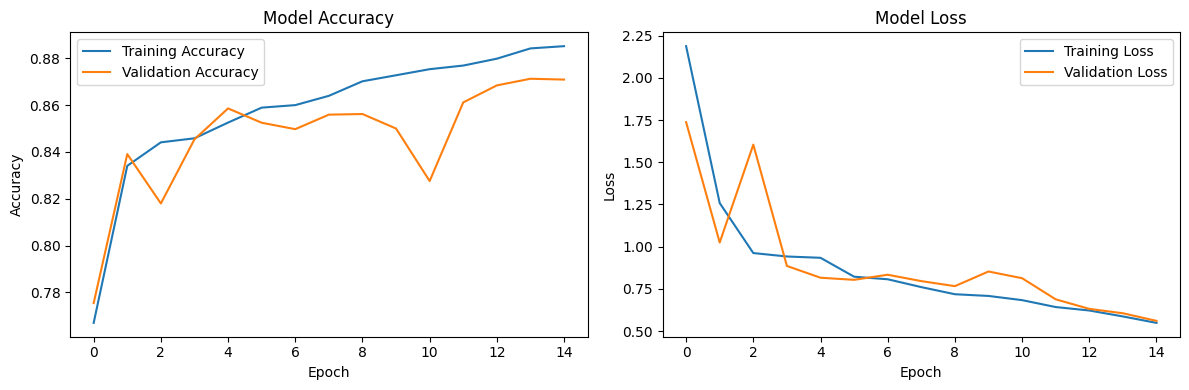

In [33]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_training_history(resnet_history)

## Xception

In [43]:
# Preprocessing function for Xception & Densenet
def preprocess_augmentation_images(image, label):
    # Resize the image to be compatile with Xception/Densenet architecture
    image = tf.image.resize(image, (128, 128))
    
    # Convert grayscale to RGB
    if image.shape[-1] == 1:  # Check if the image is grayscale
        image = tf.image.grayscale_to_rgb(image)
        
    # Flip the image left to right
    image = tf.image.flip_left_right(image)
    
    # Rotate the image 90 degrees clockwise
    image = tf.image.rot90(image, k=1)
    
    return image, label
 
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
train_dataset = train_dataset.map(preprocess_augmentation_images).batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
val_dataset = val_dataset.map(preprocess_augmentation_images).batch(64).prefetch(tf.data.AUTOTUNE)

In [90]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False

# Input shape remains the same
inputs = tf.keras.Input(shape=(128, 128, 3))

# Pass inputs through Xception base model
x = base_model(inputs, training=False)   

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)    
outputs = Dense(47, activation='softmax')(x) # Output layer with 47 classes

# Create and compile the model
model_xception = Model(inputs, outputs)
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_score])

model_xception.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 47)             │        48,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,007,831 (87.77 MB)

 Trainable params: 2,146,351 (8.19 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [45]:
Checkpoint_xception = ModelCheckpoint('xception.keras',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')

In [46]:
xception_history = model_xception.fit(train_dataset, validation_data=val_dataset,epochs=15,callbacks=[Checkpoint_xception])

Epoch 1/15
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6414 - f1_score: 0.0436 - loss: 1.2368 - precision_6: 0.7930 - recall_6: 0.5110
Epoch 1: val_accuracy improved from -inf to 0.77145, saving model to xception.keras
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 95s 56ms/step - accuracy: 0.6415 - f1_score: 0.0436 - loss: 1.2366 - precision_6: 0.7931 - recall_6: 0.5110 - val_accuracy: 0.7715 - val_f1_score: 0.0467 - val_loss: 0.6901 - val_precision_6: 0.8469 - val_recall_6: 0.7063
Epoch 2/15
1586/1587 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7891 - f1_score: 0.0501 - loss: 0.6353 - precision_6: 0.8518 - recall_6: 0.7319
Epoch 2: val_accuracy improved from 0.77145 to 0.78404, saving model to xception.keras
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.7891 - f1_score: 0.0501 - loss: 0.6353 - precision_6: 0.8518 - recall_6: 0.7319 - val_accuracy: 0.7840 - val_f1_score: 0.0517 - val_loss: 0.6424 - val_precision_6: 0.8440 - val_recall_6: 0.7340
Epoch 3/15
1586/1587 ━━━━

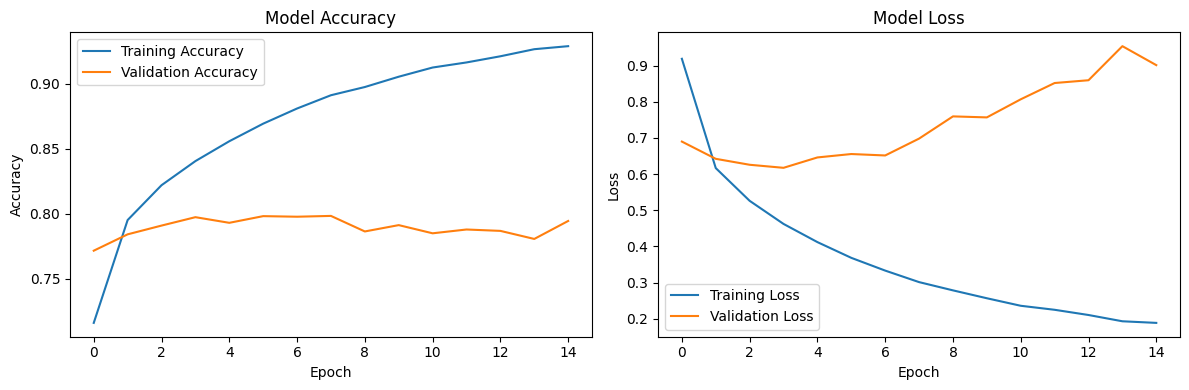

In [48]:
plot_training_history(xception_history)

## Densenet

In [91]:
from tensorflow.keras.applications import DenseNet201

# Load DenseNet201 as the base model
base_model = DenseNet201(weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze the base model

inputs = tf.keras.Input(shape=(128, 128, 3))  

# Pass the input through the DenseNet201 model
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(47, activation='softmax')(x)

# Define the model
model_densenet = Model(inputs, outputs)

# Compile the model
model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_score])

model_densenet.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 4, 4, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │     1,967,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 47)             │        48,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,337,263 (77.58 MB)

 Trainable params: 2,015,279 (7.69 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [50]:
Checkpoint_densenet = ModelCheckpoint('densenet.keras',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')

In [51]:
densenet_history = model_densenet.fit(train_dataset, validation_data=val_dataset,epochs=15,callbacks=[Checkpoint_densenet])

Epoch 1/15
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6876 - f1_score: 0.0451 - loss: 1.0749 - precision_7: 0.8238 - recall_7: 0.5691
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to densenet.keras
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 184s 92ms/step - accuracy: 0.6876 - f1_score: 0.0451 - loss: 1.0747 - precision_7: 0.8238 - recall_7: 0.5692 - val_accuracy: 0.8125 - val_f1_score: 0.0498 - val_loss: 0.5702 - val_precision_7: 0.8645 - val_recall_7: 0.7639
Epoch 2/15
1586/1587 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8237 - f1_score: 0.0538 - loss: 0.5179 - precision_7: 0.8704 - recall_7: 0.7809
Epoch 2: val_accuracy improved from 0.81250 to 0.82863, saving model to densenet.keras
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 109s 69ms/step - accuracy: 0.8237 - f1_score: 0.0538 - loss: 0.5179 - precision_7: 0.8704 - recall_7: 0.7809 - val_accuracy: 0.8286 - val_f1_score: 0.0563 - val_loss: 0.5061 - val_precision_7: 0.8699 - val_recall_7: 0.7928
Epoch 3/15
1586/1587 ━━

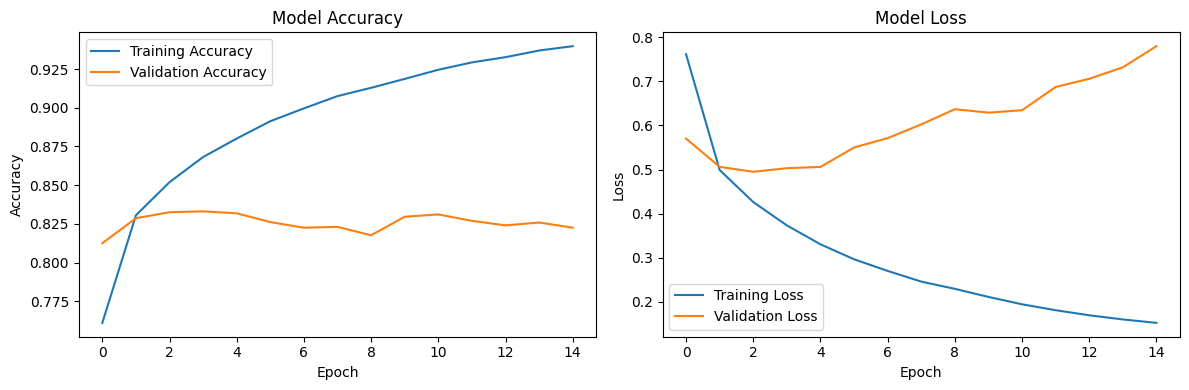

In [52]:
plot_training_history(densenet_history)

## Plots

### Precision, Recall, and F1-Score

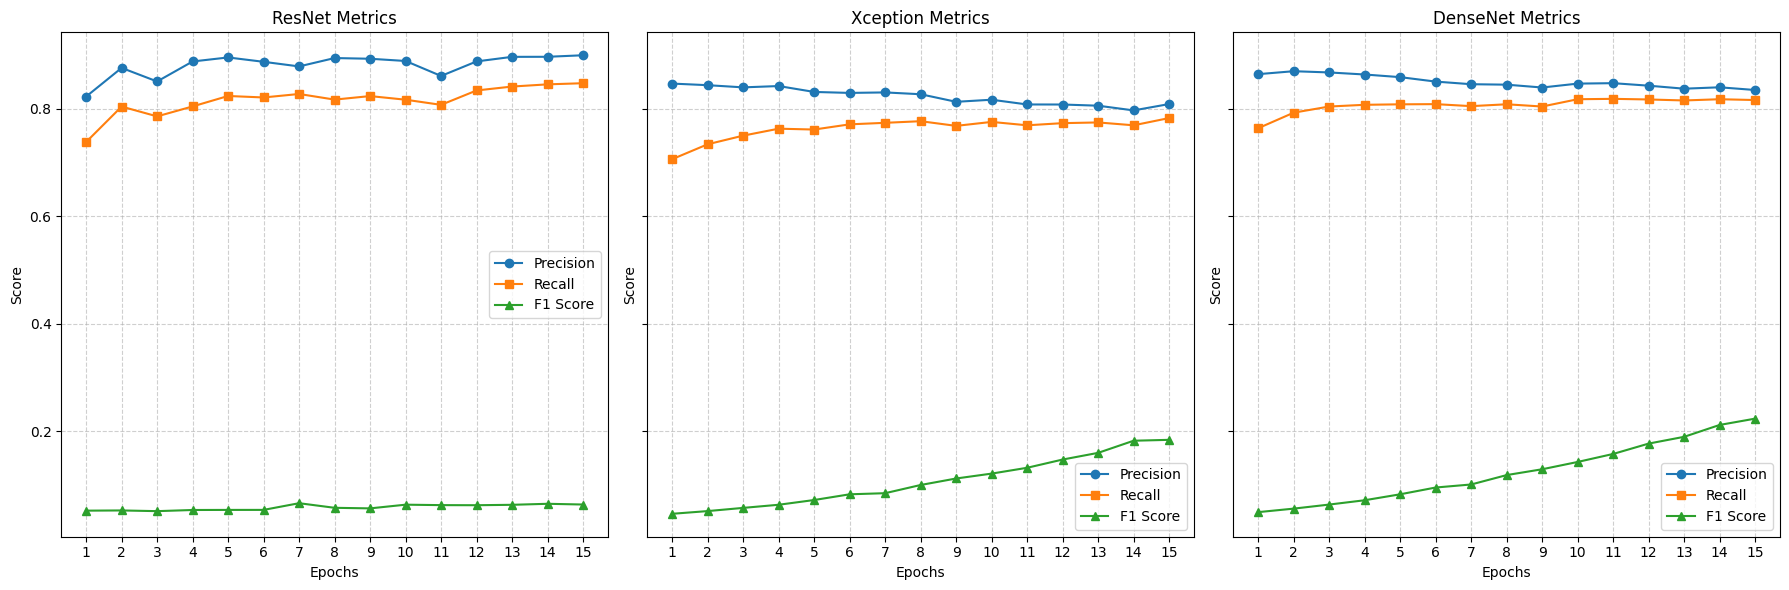

In [73]:
def plot_model_metrics(resnet_history, xception_history, densenet_history):
    # Set up the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Titles for each subplot
    model_names = ['ResNet', 'Xception', 'DenseNet']
    
    # Histories for each model
    histories = [resnet_history, xception_history, densenet_history]
    metrics_names = {
        'ResNet': ['val_precision_3', 'val_recall_3'],
        'Xception': ['val_precision_6', 'val_recall_6'],
        'DenseNet': ['val_precision_7', 'val_recall_7'],
    }

    for i, (ax, model_name, history) in enumerate(zip(axes, model_names, histories)):        

        precision = history.history.get(metrics_names[model_name][0], [])
        recall = history.history.get(metrics_names[model_name][1], [])
        f1_score = history.history.get('val_f1_score', [])
        epochs = range(1, len(precision) + 1)

        ax.plot(epochs, precision, label='Precision', marker='o')
        ax.plot(epochs, recall, label='Recall', marker='s')
        ax.plot(epochs, f1_score, label='F1 Score', marker='^')
        
        ax.set_title(f'{model_name} Metrics')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Score')
        ax.set_xticks(epochs)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

plot_model_metrics(resnet_history, xception_history, densenet_history)

### Confusion Matrix

ResNet Model


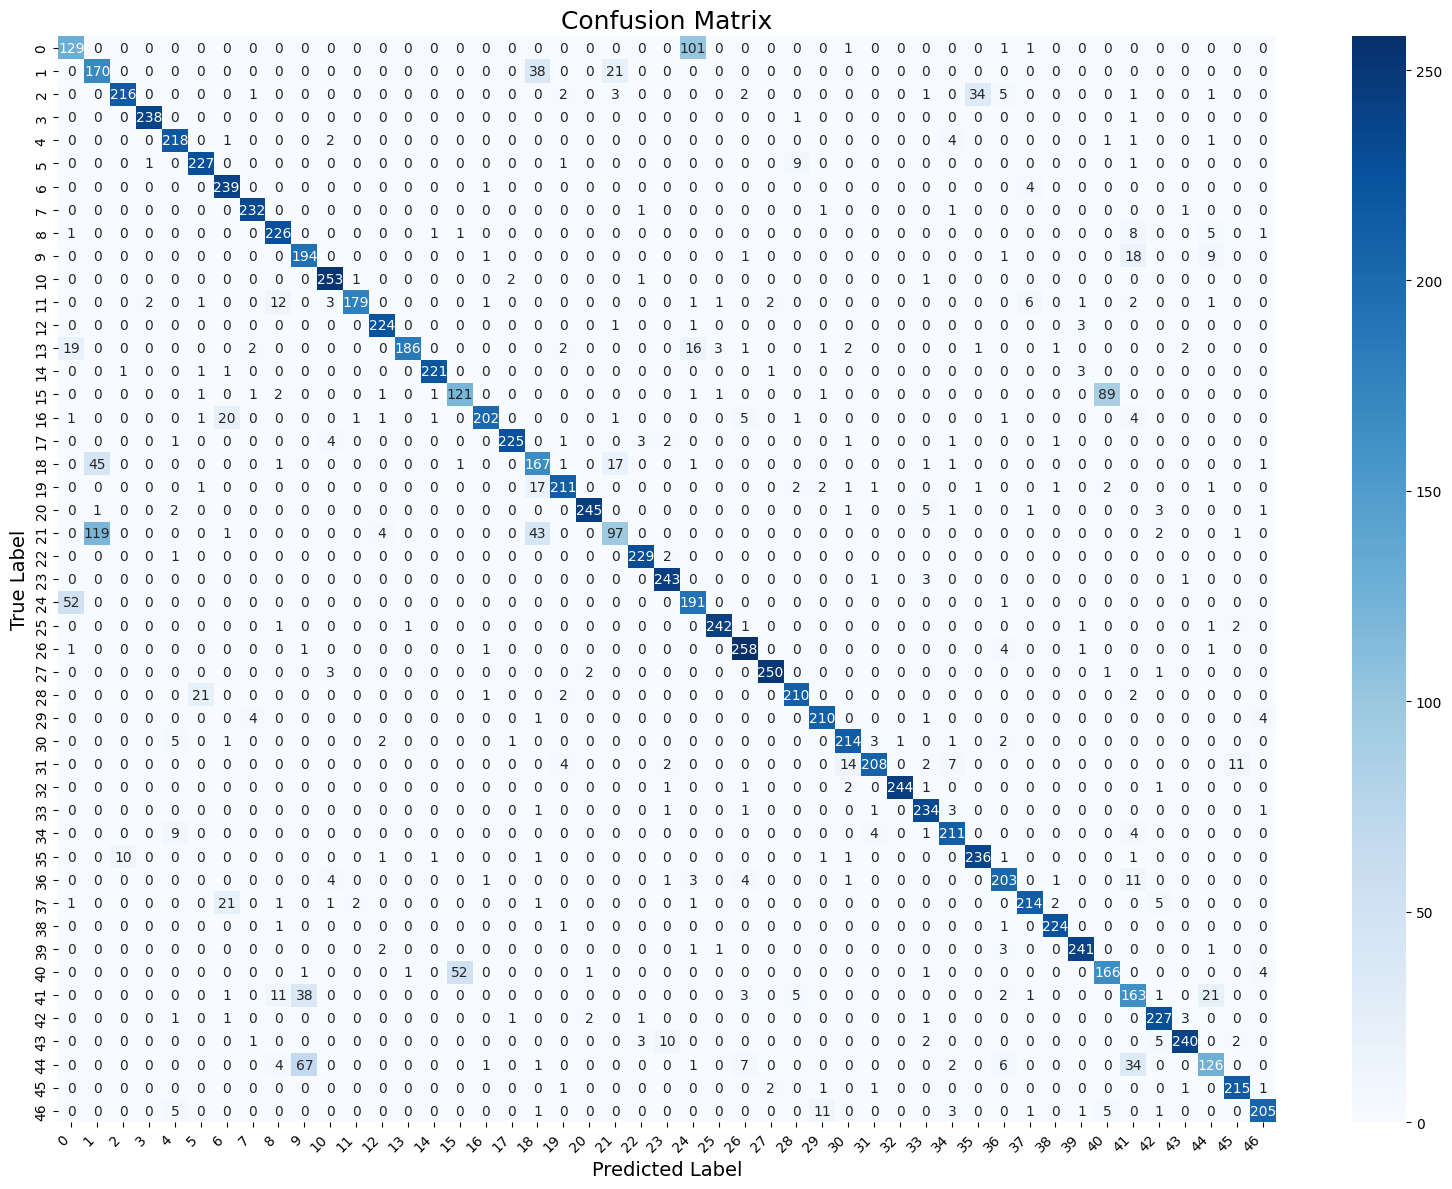

Xception Model


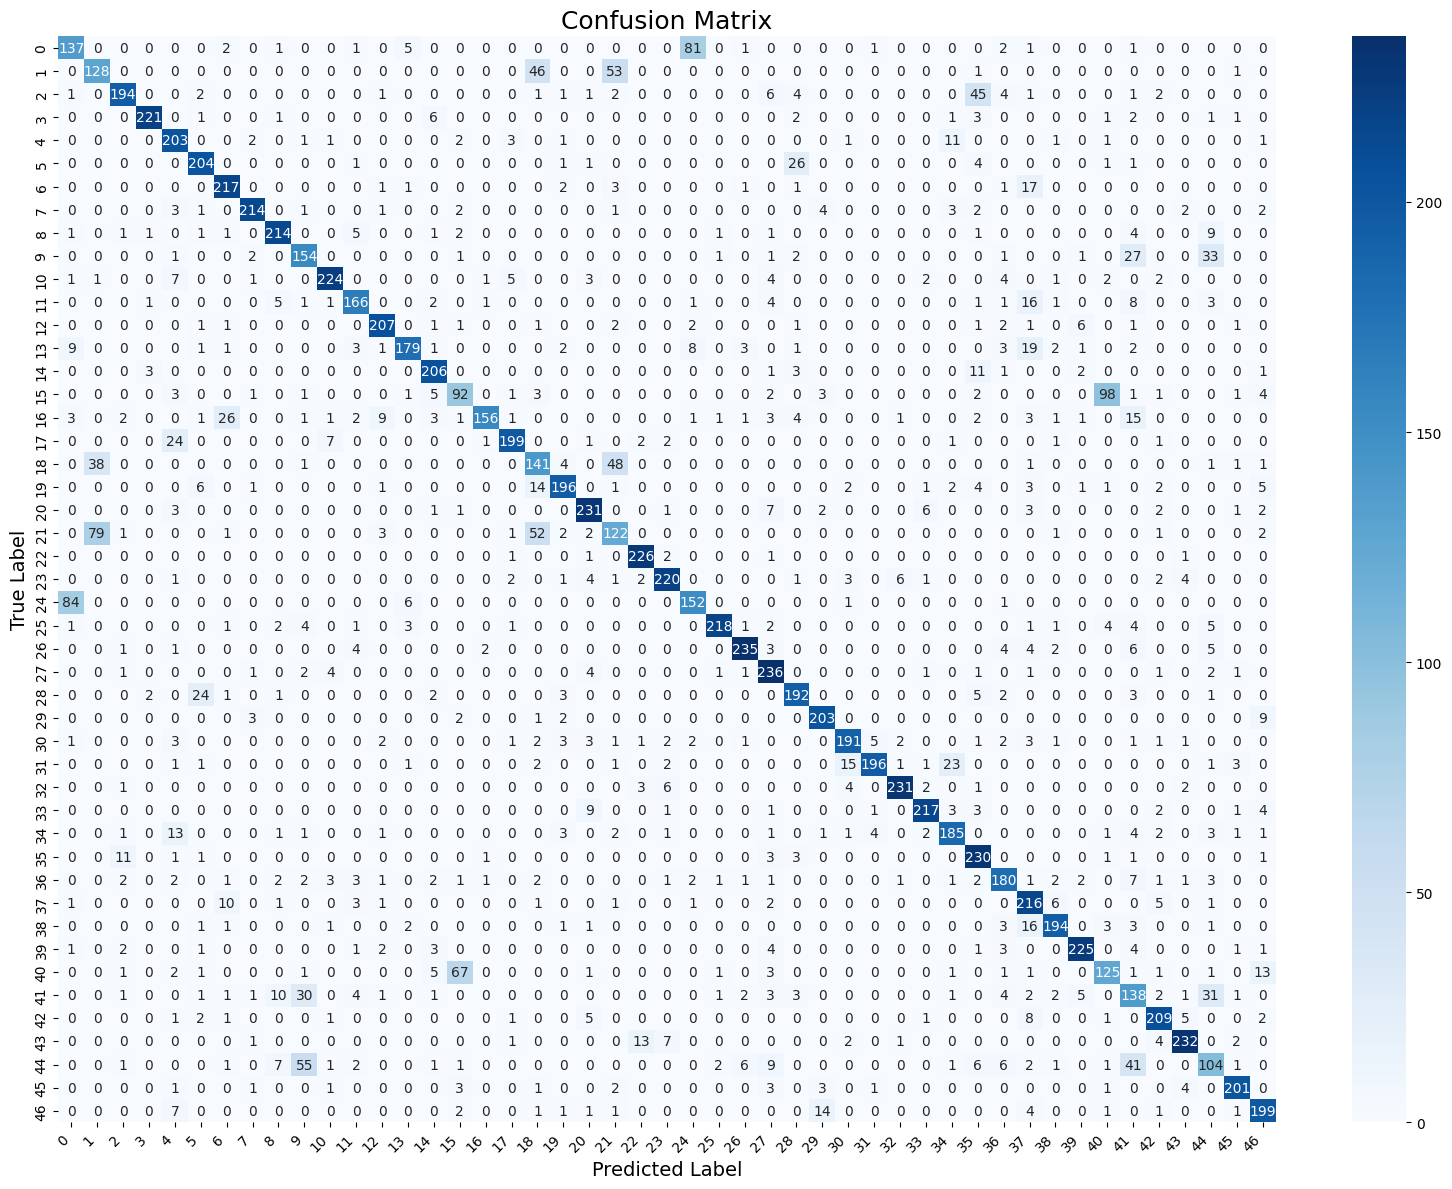

DenseNet Model


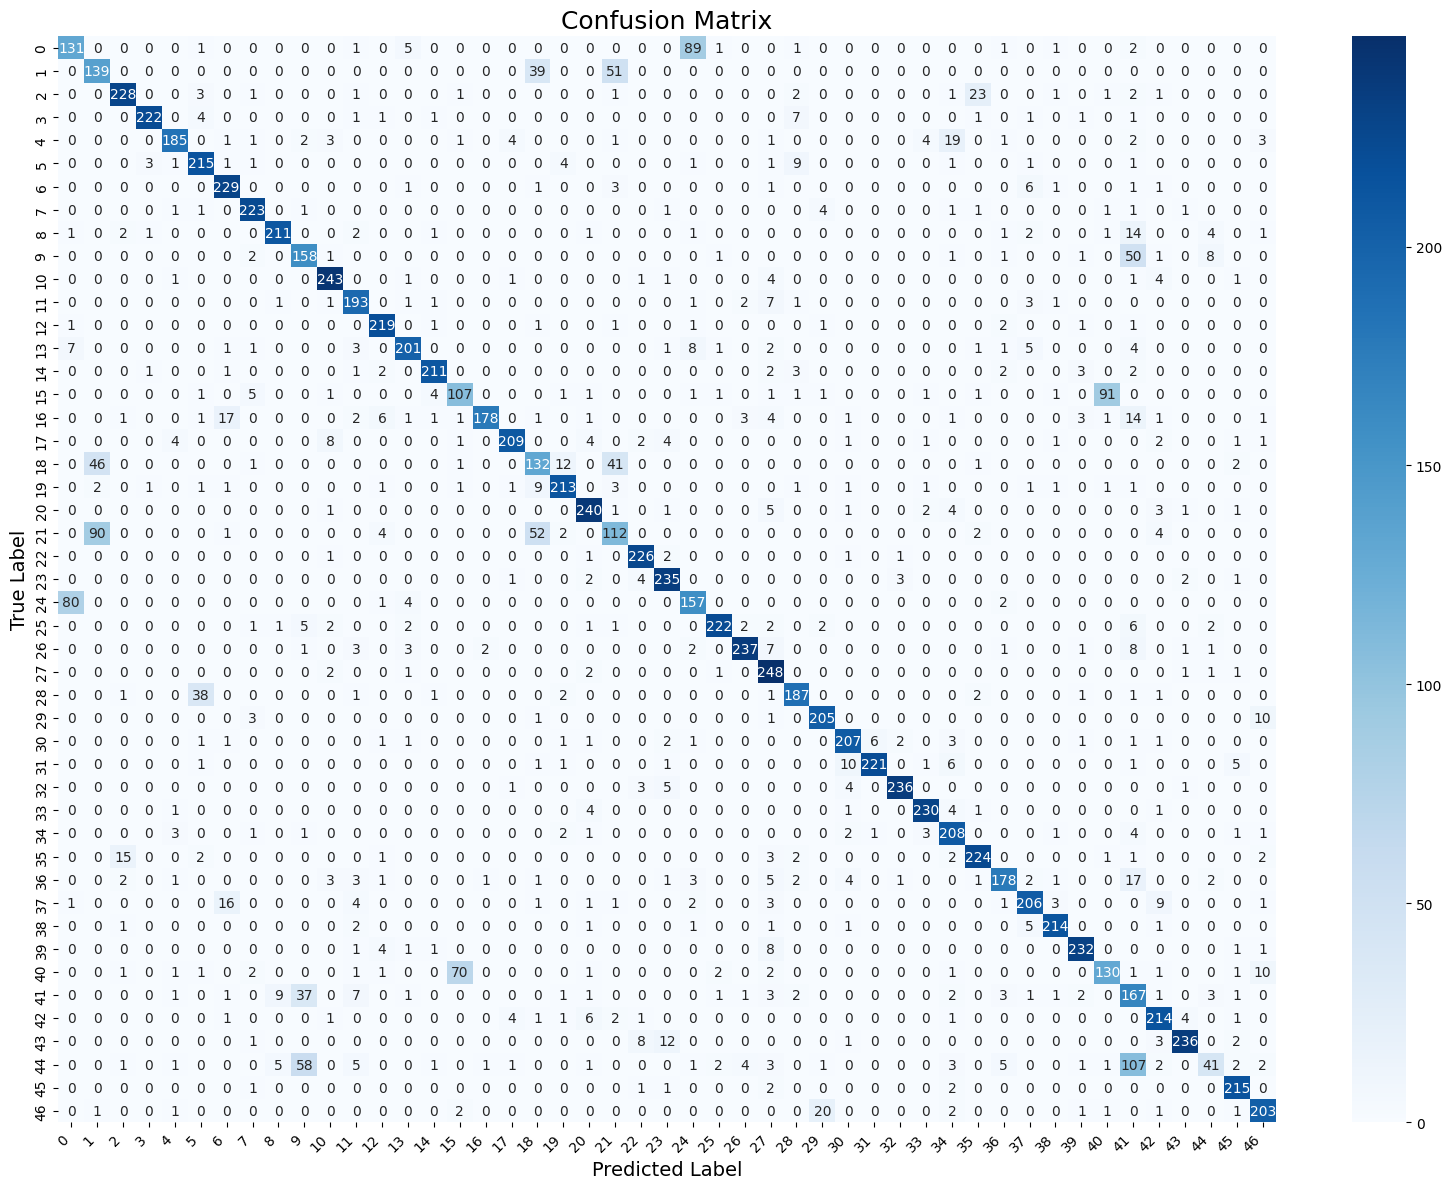

In [81]:
def plot_confusion_matrix_tf(model, dataset, class_names):
    # Extract ground truth and predictions from the dataset
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        # Append ground truth labels
        y_true.append(np.argmax(labels, axis=1))
        preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(preds, axis=1))
    
    # Concatenate all batches into single arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(16, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print('ResNet Model')
plot_confusion_matrix_tf(resnet_50, val_dataset_res, label_dictionary)

print('Xception Model')
plot_confusion_matrix_tf(model_xception, val_dataset , label_dictionary)

print('DenseNet Model')
plot_confusion_matrix_tf(model_densenet, val_dataset , label_dictionary)

### ROC/AUC

ResNet Model


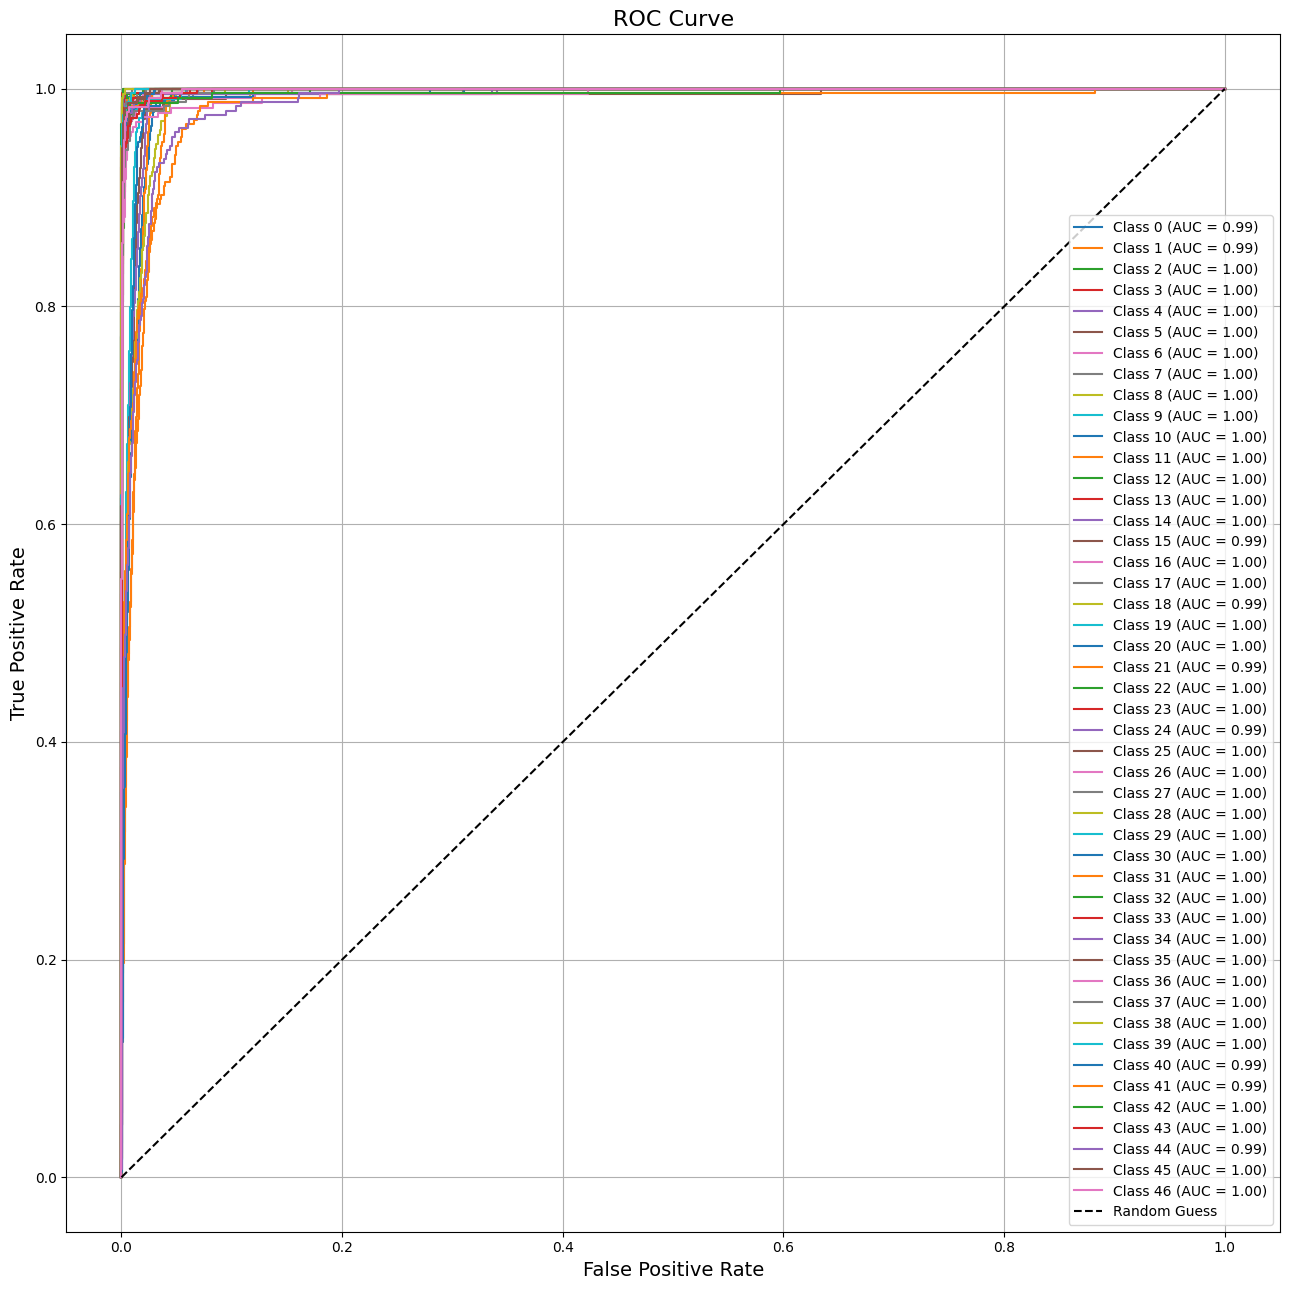

Xception Model


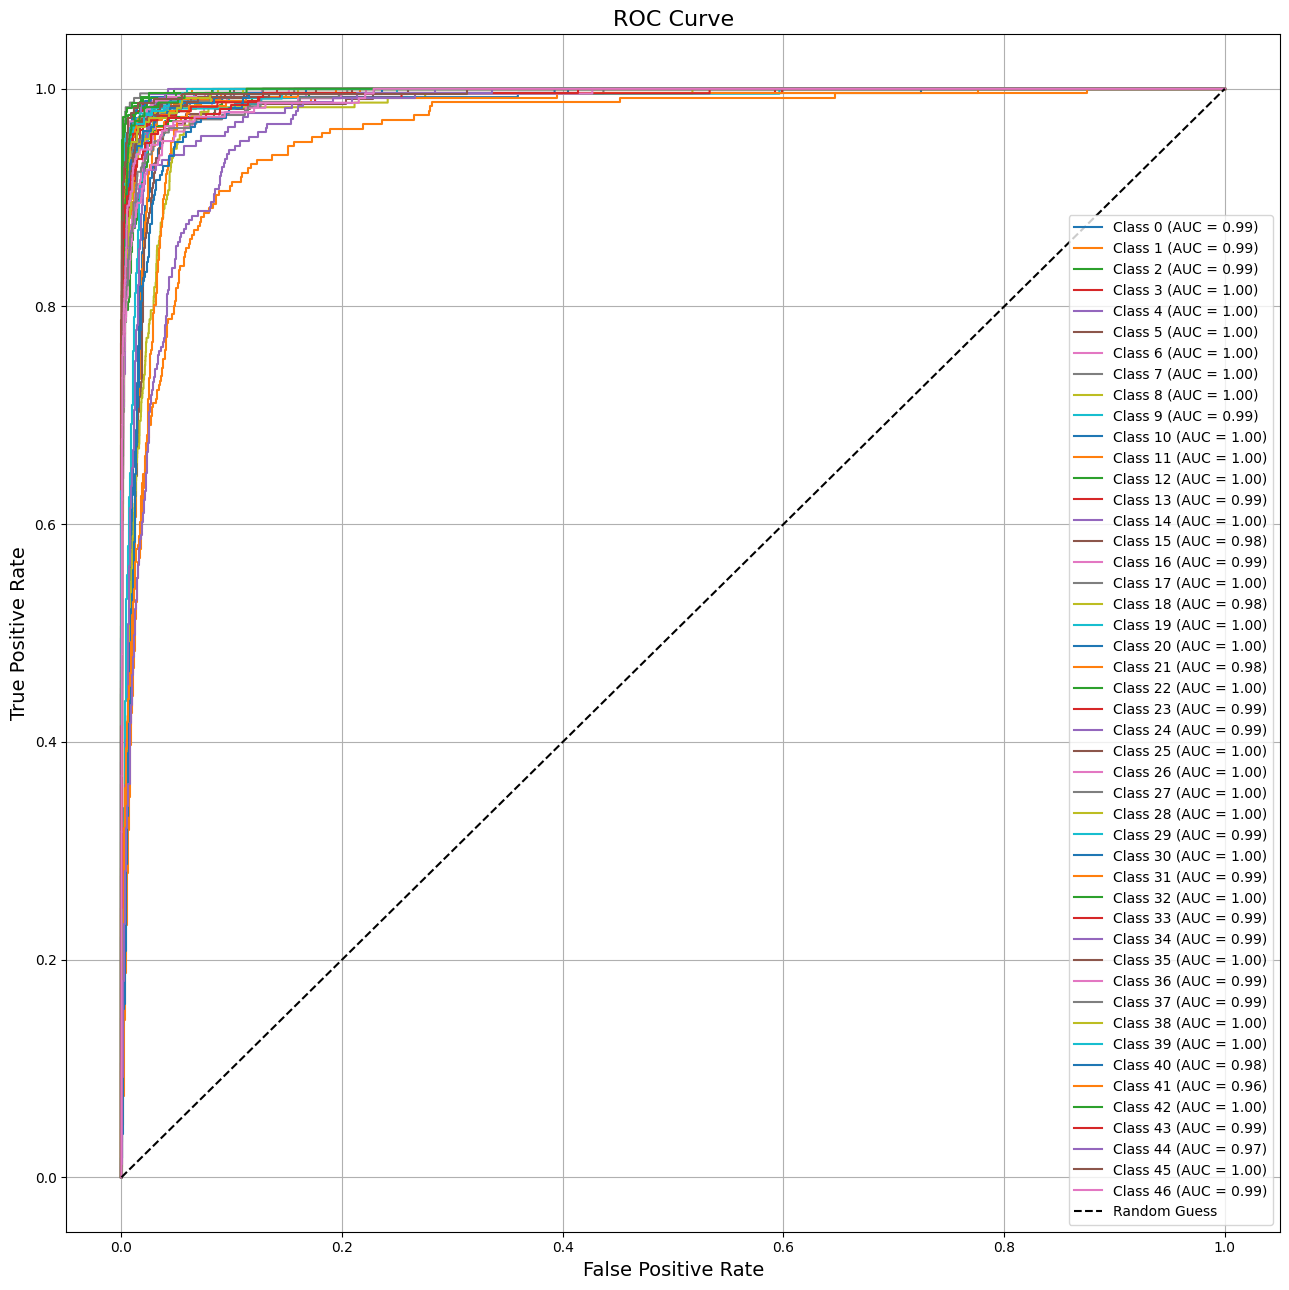

DenseNet Model


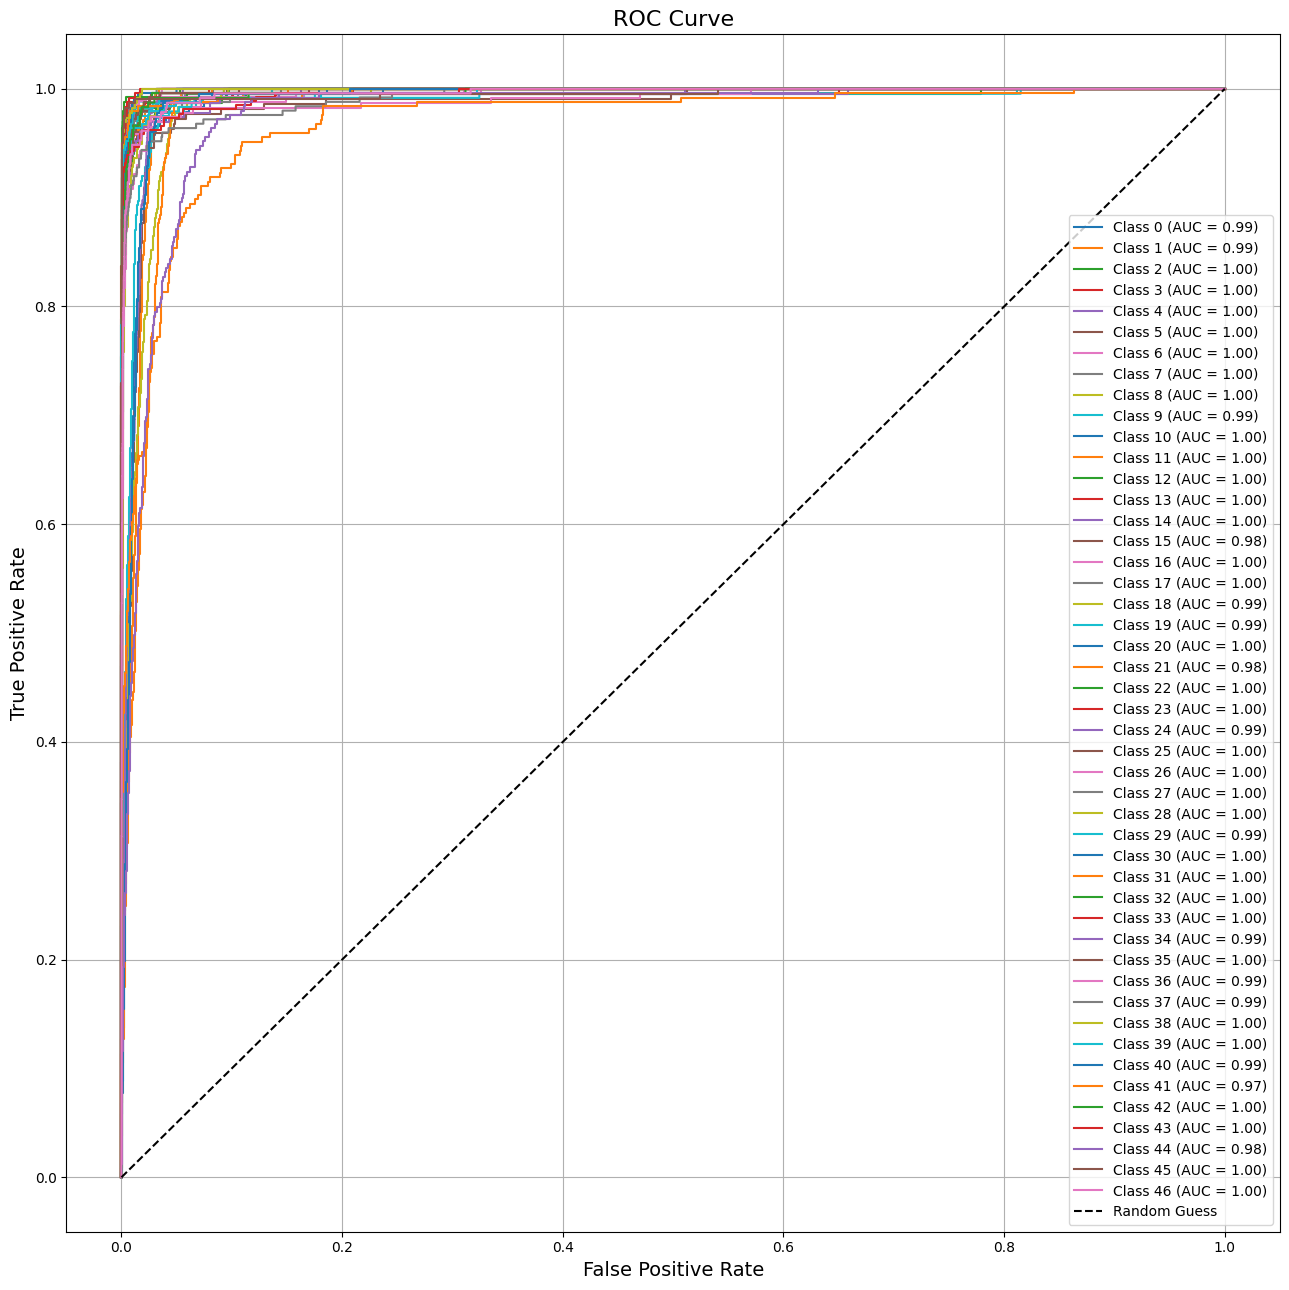

In [89]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, dataset, class_names):
    y_true = []
    y_pred_probs = []
    for images, labels in dataset:
        y_true.append(np.argmax(labels, axis=1))
        preds = model.predict(images, verbose=0)
        y_pred_probs.append(preds)

    y_true = np.concatenate(y_true)
    y_pred_probs = np.concatenate(y_pred_probs)

    y_true_binarized = label_binarize(y_true, classes=list(range(len(class_names))))
    plt.figure(figsize=(13, 13))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title("ROC Curve", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

print('ResNet Model')
plot_roc_curve(resnet_50, val_dataset_res, label_dictionary)

print('Xception Model')
plot_roc_curve(model_xception, val_dataset , label_dictionary)

print('DenseNet Model')
plot_roc_curve(model_densenet, val_dataset , label_dictionary)

**Upload weights as a dataset for the GUI**

In [98]:
import json

# Set Kaggle enviroment keys
os.environ['KAGGLE_USERNAME'] = 'oyounis'
os.environ['KAGGLE_KEY'] = '46cf0fce74b3419800d090108b472763'

from kaggle.api.kaggle_api_extended import KaggleApi

# Metadata file
metadata = {
    "title": "model-weights-dataset",
    "id": "oyounis/model-weights-dataset",
    "licenses": [
        {
            "name": "CC0-1.0"
        }
    ]
}

# Write metadata to a file
metadata_path = '/kaggle/working/dataset-metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f)
    
# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Define weight files to include
weight_files = [
    '/kaggle/working/densenet.keras',
    '/kaggle/working/resnet.keras',
    '/kaggle/working/xception.keras',
]

# Create dataset
api.dataset_create_new(
    folder='/kaggle/working',
    convert_to_csv=False,
)

Starting upload for file xception.keras


100%|██████████| 105M/105M [00:03<00:00, 30.3MB/s] 


Upload successful: xception.keras (105MB)
Skipping folder: .virtual_documents; use '--dir-mode' to upload folders
Starting upload for file resnet.keras


100%|██████████| 267M/267M [00:07<00:00, 37.4MB/s] 


Upload successful: resnet.keras (267MB)
Skipping folder: weights; use '--dir-mode' to upload folders
Starting upload for file densenet.keras


100%|██████████| 95.2M/95.2M [00:03<00:00, 30.1MB/s]


Upload successful: densenet.keras (95MB)


https://www.kaggle.com/datasets/oyounis/model-weights-dataset